In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import display
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
import yaml

#### Helpers ####
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from helpers.s3_bucket_utils import S3BucketUtils
from helpers import db_utils
from helpers import settings

bucket = S3BucketUtils()
################

churn_based_on_behaviour_dir = 'churn_analysis_based_on_behaviour/'

In [2]:
with open(r'./parameters/started_doing_something_report_parameters.yaml') as file:
    model_params = yaml.load(file, Loader=yaml.FullLoader)

date_of_analysis = model_params['date_of_analysis']
date_dir = date_of_analysis.replace('-', '_')

In [3]:
data_sets = ['data_tv_ALL_spots_with_CB_wo_151617.csv',\
             'data_tv_ALL_spots_wo_CB_wo_151617.csv',\
             'data_tv_CAN_CANCEL_spots_with_CB_wo_151617.csv',\
             'data_tv_CAN_CANCEL_spots_wo_CB_wo_151617.csv']

filename = data_sets[0].split('_wo_151617.csv')[0]

In [4]:
df = \
bucket.load_csv_from_s3(file_name='churn_analysis/data/'+date_dir+'/'+filename+'_wo_151617.csv')

### All metro areas together

Variable: private.parties.submissions.total
Number of spots: 3082
Number of metro areas: 81


,month,private.parties.submissions.total
25,2020-03-01,3.495146
26,2020-04-01,0.570470
27,2020-05-01,0.951923
28,2020-06-01,2.323263
29,2020-07-01,1.779817
30,2020-08-01,2.453216
31,2020-09-01,3.125000
32,2020-10-01,3.867788
33,2020-11-01,2.818605
34,2020-12-01,1.922727


Variable: reservations.submissions.total
Number of spots: 1342
Number of metro areas: 73


,month,reservations.submissions.total
25,2020-03-01,8.197368
26,2020-04-01,0.098592
27,2020-05-01,3.756410


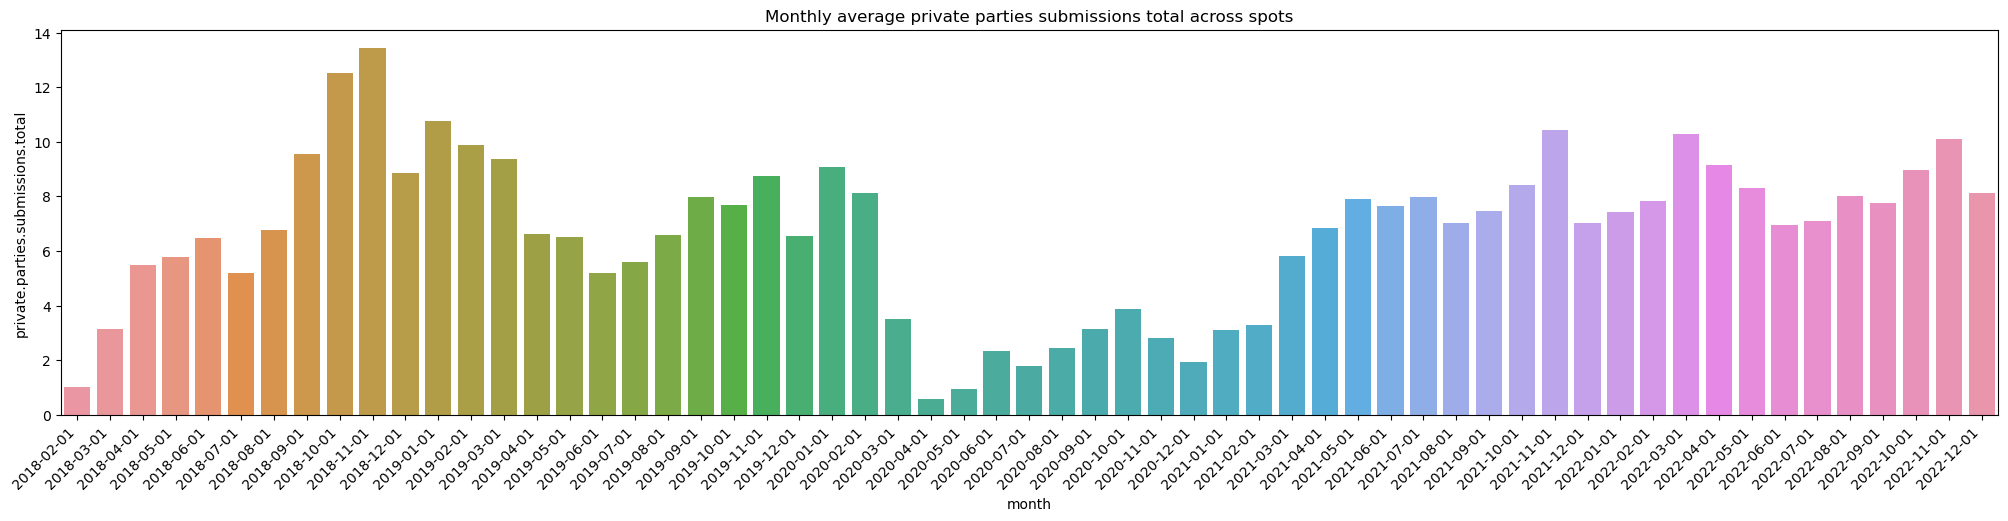

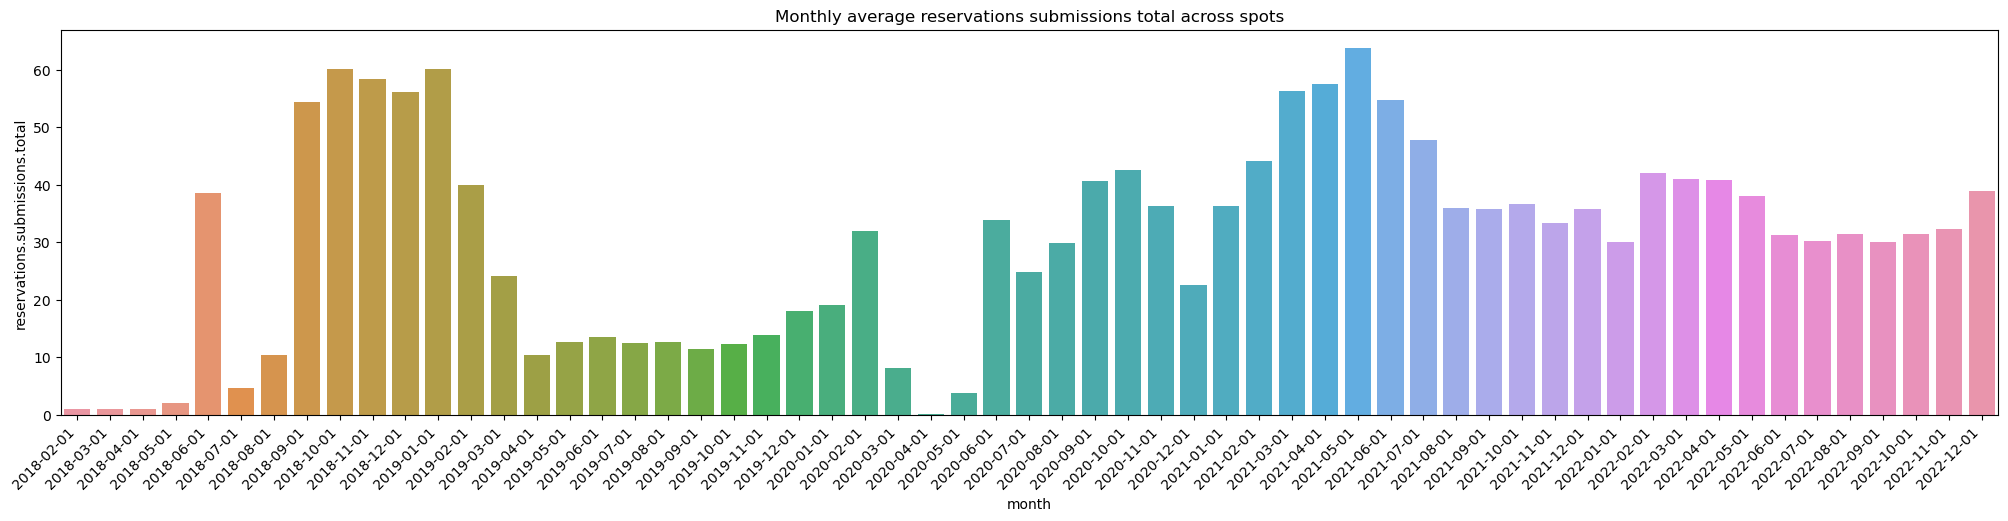

In [5]:
groupby_keys = ['left_limit']
threshold_value = 0.7
for var_of_interest in ['private.parties.submissions.total',\
                        #'PP.Changed.inquiry.status.total',\
                       'reservations.submissions.total',\
                        #'R.Changed.inquiry.status.total'
                       ]:
    
    spots_of_interest = df[df[var_of_interest]>0]['spot_id'].unique()
    
    df_tmp = df[df['spot_id'].isin(spots_of_interest)].copy()

    df_tmp = df_tmp.merge(df_tmp[df_tmp[var_of_interest]>0].groupby('spot_id')['left_limit'].min().\
        reset_index().rename(columns = {'left_limit':var_of_interest+'_start'}), on = ['spot_id'])

    df_tmp = df_tmp.merge(df_tmp[df_tmp[var_of_interest]>0].groupby('spot_id')['left_limit'].max().\
    reset_index().rename(columns = {'left_limit':var_of_interest+'_end'}), on = ['spot_id'])

    df_tmp.drop(df_tmp[(df_tmp['left_limit']<df_tmp[var_of_interest+'_start'])|\
                      (df_tmp['left_limit']>df_tmp[var_of_interest+'_end'])].index, inplace = True)

    df_tmp = df_tmp.merge(df_tmp.groupby('spot_id')['time'].\
    count().reset_index().rename(columns = {'time':var_of_interest+'_total_num_of_months'}),\
             on = ['spot_id'])
    
    avg_values = df_tmp.groupby(groupby_keys)[var_of_interest].mean().reset_index()
    avg_values.rename(columns = {'left_limit':'month'}, inplace = True)
    
    print('Variable: '+var_of_interest)
    print('Number of spots: '+str(df_tmp['spot_id'].nunique()))
    print('Number of metro areas: '+str(df_tmp['metro_area'].nunique()))
    
    total_avg_value = avg_values[var_of_interest].mean()
    display(avg_values[(avg_values[var_of_interest]<threshold_value*total_avg_value)&\
          (avg_values['month']>='2020-03-01')])
    
    plt.figure(figsize = (25, 5))
    chart = sns.barplot(x = 'month', y = var_of_interest, data = avg_values)
    # plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title('Monthly average '+var_of_interest.replace('.', ' ')+' across spots')
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [6]:
#####################################################################################################

In [7]:
### split metro areas into groups ###

In [8]:
groupby_keys = ['metro_area']
vars_of_interest = ['private.parties.submissions.total',\
                        #'PP.Changed.inquiry.status.total',\
                       'reservations.submissions.total',\
                        #'R.Changed.inquiry.status.total'
                       ]
metro_areas_in_the_same_cluster = dict.fromkeys(vars_of_interest)

for var_of_interest in vars_of_interest:
    
    metro_areas_in_the_same_cluster[var_of_interest] = []
    
    spots_of_interest = df[df[var_of_interest]>0]['spot_id'].unique()
    df_tmp = df[df['spot_id'].isin(spots_of_interest)].copy()
    df_tmp = df_tmp.merge(df_tmp[df_tmp[var_of_interest]>0].groupby('spot_id')['left_limit'].min().\
        reset_index().rename(columns = {'left_limit':var_of_interest+'_start'}), on = ['spot_id'])
    df_tmp = df_tmp.merge(df_tmp[df_tmp[var_of_interest]>0].groupby('spot_id')['left_limit'].max().\
    reset_index().rename(columns = {'left_limit':var_of_interest+'_end'}), on = ['spot_id'])
    df_tmp.drop(df_tmp[(df_tmp['left_limit']<df_tmp[var_of_interest+'_start'])|\
                      (df_tmp['left_limit']>df_tmp[var_of_interest+'_end'])].index, inplace = True)
    df_tmp = df_tmp.merge(df_tmp.groupby('spot_id')['time'].\
    count().reset_index().rename(columns = {'time':var_of_interest+'_total_num_of_months'}),\
             on = ['spot_id'])
    
#     avg_values = df_tmp.groupby(groupby_keys)[var_of_interest].mean().reset_index()
#     avg_values.rename(columns = {'left_limit':'month'}, inplace = True)
    
    avg_values = df_tmp.groupby(['left_limit', 'metro_area'])[var_of_interest].mean().\
    reset_index()
    avg_values.rename(columns = {'left_limit':'month'}, inplace = True)

    avg_values = avg_values.groupby('metro_area')[var_of_interest].mean().\
    reset_index()
    
    X = avg_values.copy()
    # k-means clustering
    X, _ = make_classification(n_samples=len(avg_values), n_features=3, n_informative=3, n_redundant=0, n_clusters_per_class=1, random_state=4)
    # define the model
    model = KMeans(n_clusters=2)
    # fit the model
    model.fit(X)
    # assign a cluster to each example
    yhat = model.predict(X)
    # retrieve unique clusters
    clusters = unique(yhat)
    
    clusters = pd.concat([avg_values, pd.DataFrame(yhat, columns = ['cluster'])], axis = 1)
    for cluster in clusters['cluster'].unique():
        metro_areas_in_the_same_cluster[var_of_interest].append(list(clusters[clusters['cluster']==cluster]['metro_area'].unique()))

Variable: private.parties.submissions.total
Number of metro areas in this group: 53
Metro areas: ['Albuquerque', 'Austin', 'Baltimore', 'Birmingham', 'Boulder', 'Brooklyn', 'Buffalo', 'Charleston', 'Charlottesville', 'Chattanooga', 'Chicago', 'Cincinnati', 'Cleveland', 'Connecticut', 'Dallas', 'Denver', 'Fort Collins', 'Fort Myers', 'Greenville South Carolina', 'Hartford', 'Honolulu', 'Indianapolis', 'Irvine', 'Jacksonville', 'Las Vegas', 'Madison', 'Miami', 'Milford CT', 'Milwaukee', 'Minneapolis', 'Nashville', 'New Jersey', 'Oklahoma City', 'Philadelphia', 'Phoenix', 'Pittsburgh', 'Portland', 'Portland Maine', 'Providence', 'Raleigh', 'Sacramento', 'Salt Lake City', 'San Antonio', 'San Bernardino', 'San Diego', 'Savannah', 'Seattle', 'Sedona', 'St. Louis', 'Tucson', 'Washington DC', 'Winston-Salem', 'dontKnow']
Number of spots: 1935


,month,private.parties.submissions.total
25,2020-03-01,3.050562
26,2020-04-01,0.689266
27,2020-05-01,1.150538
28,2020-06-01,2.916667
29,2020-07-01,1.935484
30,2020-08-01,2.627660
31,2020-09-01,3.078049
32,2020-10-01,3.704036
33,2020-11-01,2.709957
34,2020-12-01,2.046218


Variable: private.parties.submissions.total
Number of metro areas in this group: 28
Metro areas: ['Atlanta', 'Boston', 'Charlotte', 'Columbus', 'Des Moines', 'Detroit', 'Dover', 'Fort Lauderdale', 'Fort Worth', 'Houston', 'Iowa City', 'Kansas City', 'Los Angeles', 'Louisville', 'Memphis', 'Myrtle Beach', 'New Orleans', 'New York', 'Omaha', 'Orange County', 'Orlando', 'Palm Springs', 'Richmond', 'San Francisco', 'San Jose', 'Santa Cruz', 'Tampa Bay', 'Virginia Beach']
Number of spots: 1147


,month,private.parties.submissions.total
24,2020-03-01,4.099237
25,2020-04-01,0.396694
26,2020-05-01,0.658730
27,2020-06-01,1.503597
28,2020-07-01,1.574468
29,2020-08-01,2.240260
30,2020-09-01,3.181287
31,2020-10-01,4.056995
32,2020-11-01,2.944724
33,2020-12-01,1.777228


Variable: reservations.submissions.total
Number of metro areas in this group: 44
Metro areas: ['Albuquerque', 'Atlanta', 'Baltimore', 'Boston', 'Boulder', 'Buffalo', 'Charlotte', 'Charlottesville', 'Chattanooga', 'Chicago', 'Cincinnati', 'Cleveland', 'Columbus', 'Connecticut', 'Des Moines', 'Dover', 'Fort Collins', 'Fort Worth', 'Greenville South Carolina', 'Hartford', 'Honolulu', 'Houston', 'Indianapolis', 'Las Vegas', 'Los Angeles', 'Madison', 'Memphis', 'Nashville', 'Omaha', 'Orlando', 'Pittsburgh', 'Raleigh', 'Richmond', 'Sacramento', 'Salt Lake City', 'San Antonio', 'San Diego', 'San Francisco', 'Santa Cruz', 'Seattle', 'Sedona', 'St. Louis', 'Tampa Bay', 'Virginia Beach']
Number of spots: 685


,month,reservations.submissions.total
25,2020-03-01,4.1
26,2020-04-01,0.1
27,2020-05-01,6.0


Variable: reservations.submissions.total
Number of metro areas in this group: 29
Metro areas: ['Austin', 'Birmingham', 'Charleston', 'Dallas', 'Denver', 'Detroit', 'Fort Lauderdale', 'Fort Myers', 'Irvine', 'Jacksonville', 'Kansas City', 'Miami', 'Milwaukee', 'Minneapolis', 'Myrtle Beach', 'New Jersey', 'New Orleans', 'New York', 'Oklahoma City', 'Orange County', 'Philadelphia', 'Phoenix', 'Portland', 'Portland Maine', 'Providence', 'San Bernardino', 'Tucson', 'Washington DC', 'Winston-Salem']
Number of spots: 657


,month,reservations.submissions.total
22,2020-03-01,10.869565
23,2020-04-01,0.097561
24,2020-05-01,1.930233
25,2020-06-01,13.673077
26,2020-07-01,13.641509
27,2020-08-01,20.482759
31,2020-12-01,17.597561


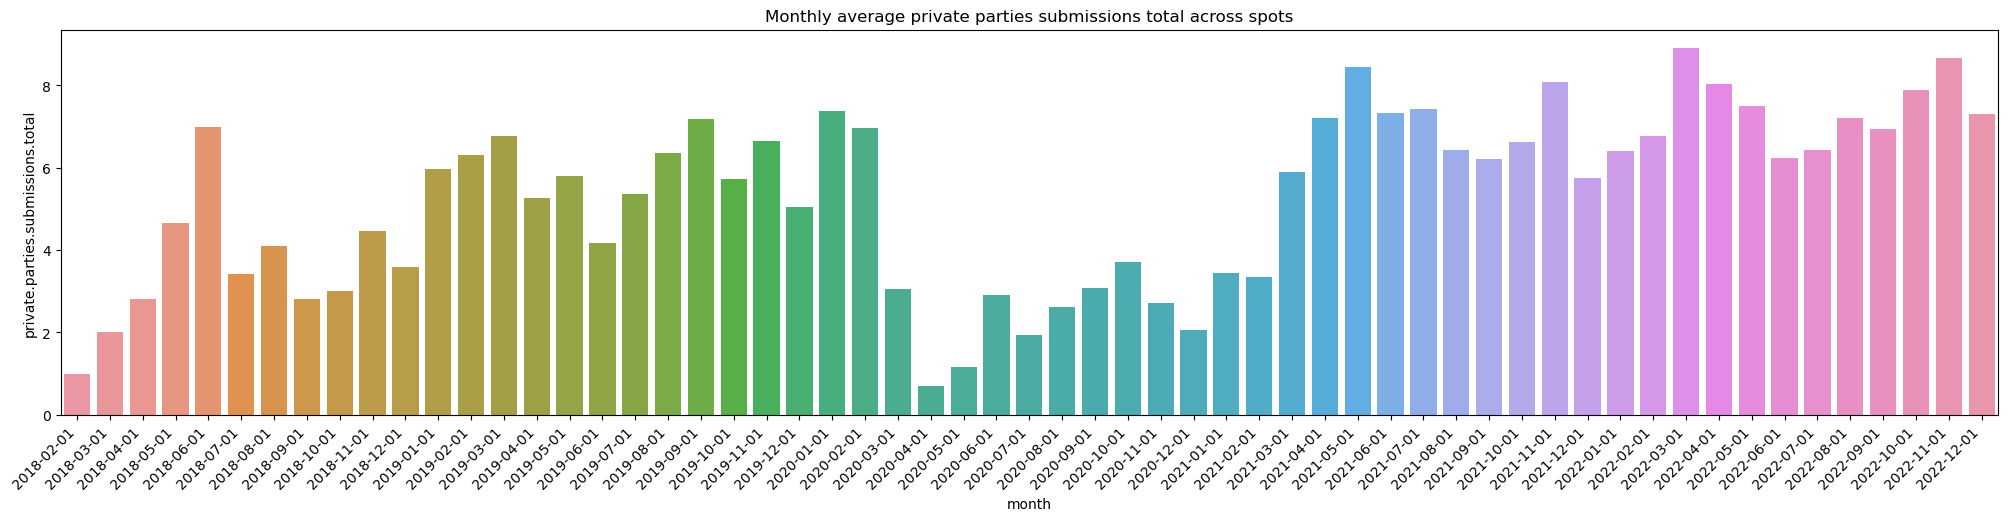

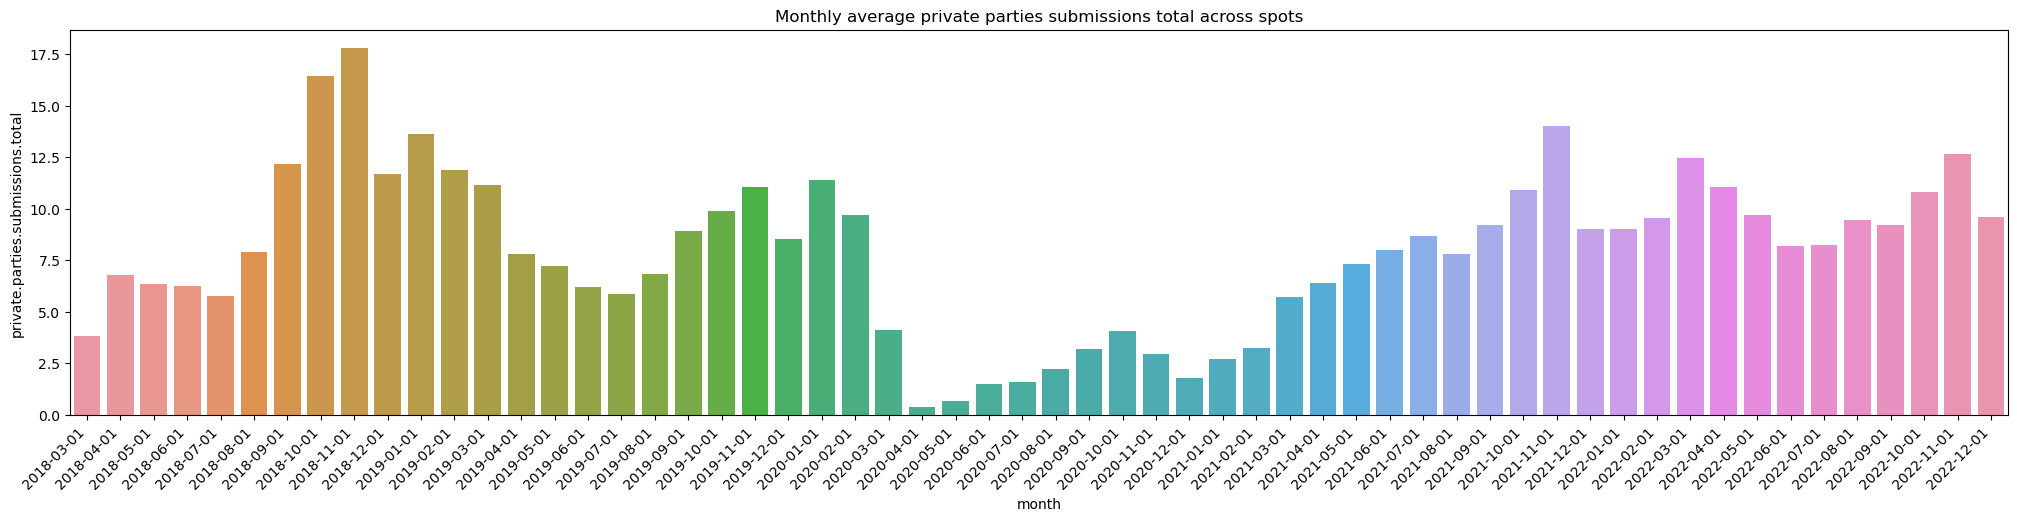

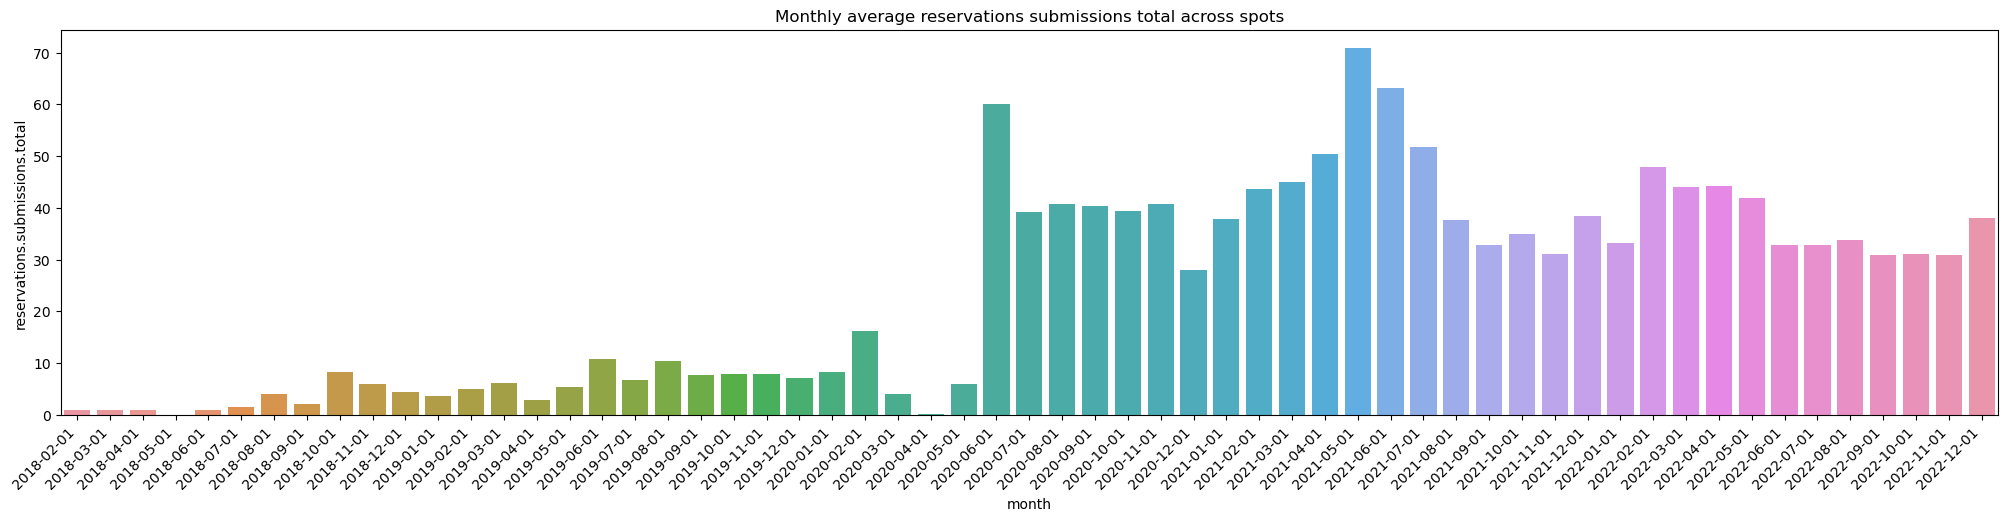

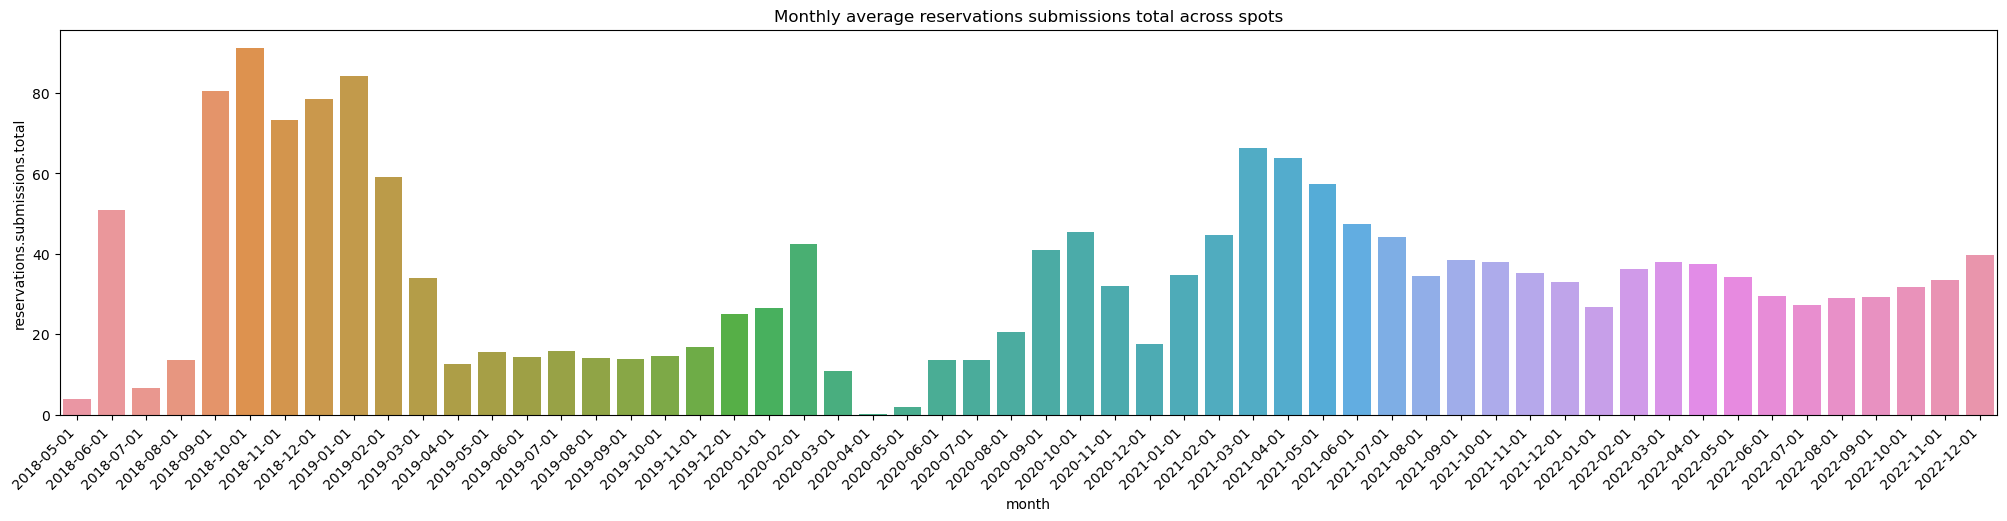

In [22]:
groupby_keys = ['left_limit']
for var_of_interest in vars_of_interest:
    i = 0
    for metro_areas in metro_areas_in_the_same_cluster[var_of_interest]:
        spots_of_interest = df[(df[var_of_interest]>0)&\
                          (df['metro_area'].isin(metro_areas))]['spot_id'].unique()

        df_tmp = df[df['spot_id'].isin(spots_of_interest)].copy()

        df_tmp = df_tmp.merge(df_tmp[df_tmp[var_of_interest]>0].groupby('spot_id')['left_limit'].min().\
            reset_index().rename(columns = {'left_limit':var_of_interest+'_start'}), on = ['spot_id'])

        df_tmp = df_tmp.merge(df_tmp[df_tmp[var_of_interest]>0].groupby('spot_id')['left_limit'].max().\
        reset_index().rename(columns = {'left_limit':var_of_interest+'_end'}), on = ['spot_id'])

        df_tmp.drop(df_tmp[(df_tmp['left_limit']<df_tmp[var_of_interest+'_start'])|\
                          (df_tmp['left_limit']>df_tmp[var_of_interest+'_end'])].index, inplace = True)

        df_tmp = df_tmp.merge(df_tmp.groupby('spot_id')['time'].\
        count().reset_index().rename(columns = {'time':var_of_interest+'_total_num_of_months'}),\
                 on = ['spot_id'])

        avg_values = df_tmp.groupby(groupby_keys)[var_of_interest].mean().reset_index()
        avg_values.rename(columns = {'left_limit':'month'}, inplace = True)

        print('Variable: '+var_of_interest)
        print('Number of metro areas in this group: '+str(len(metro_areas)))
        print('Metro areas: '+str(metro_areas))
        pd.DataFrame(metro_areas, columns = ['metro_area']).to_csv('./data/'+date_dir+'/covid_period_analysis/'+var_of_interest.replace('.', '_')+'_metro_areas_group_'+str(i+1)+'.csv', \
                                                                index = False)
        i = i + 1
        print('Number of spots: '+str(df_tmp['spot_id'].nunique()))
    #         print('Number of metro areas: '+str(df_tmp['metro_area'].nunique()))

        total_avg_value = avg_values[var_of_interest].mean()

        display(avg_values[(avg_values[var_of_interest]<threshold_value*total_avg_value)&\
              (avg_values['month']>='2020-03-01')])

        plt.figure(figsize = (25, 5))
        chart = sns.barplot(x = 'month', y = var_of_interest, data = avg_values)
        # plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        plt.title('Monthly average '+var_of_interest.replace('.', ' ')+' across spots')
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

In [21]:
!ls -la data/2023_01_01/

total 12
drwxrwxr-x 3 urqwan urqwan 4096 јан  5 11:59 .
drwxrwxr-x 5 urqwan urqwan 4096 јан  5 11:58 ..
drwxrwxr-x 2 urqwan urqwan 4096 јан  5 11:59 covid_period_analysis
